# 机器学习作业一：KNN
- 姓名：胡博浩
- 学号：2212998
- 专业：信息安全

### 实验要求
题目：基于KNN 的手写数字识别
实验条件：给定semeion手写数字数据集，给定kNN分类算法
实验要求：
1. 初级要求：编程实现kNN算法；给出在不同k值（5，9，13）情况下，kNN算法对手写数字的识别精度（要求采用留一法）
2. 中级要求：与机器学习包或平台(如weka)中的kNN分类器结果进行对比，性能指标为精度ACC，其他指标如归一化互信息NMI、混淆熵CEN任选其一（或两者）
3. 高级要求：采用旋转等手段对原始数据进行处理，进行至少两个方向（左上，左下）旋转，采用CNN或其他深度学习方法实现手写体识别

**环境**：conda python 3.9.18 + vscode

代码都进行了适当注释和分析，感谢助教的批阅！辛苦！

### 导入需要的包
这里设置随机数种子，保证结果可重复

In [2]:
from collections import Counter
from random import choice

import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
from pycm import ConfusionMatrix  # 混淆熵CEN
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# 设置随机种子
np.random.seed(42)

### 导入数据集 semeion

将semeion.data文件中的数据进行读取并转换为适当的格式。

将图像数据存储到X中，将类别标签存储到Y中，并且实现独热编码类别的转换。

<span style="color:red">由于图像数据信息是0/1组成的二值图像数据，并不需要对数据进行规范化操作。</span>

In [3]:
# 导入数据并处理
def load_semeion_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    num_samples = len(lines)
    X = np.zeros((num_samples, 256))  # 图像数据矩阵
    Y = np.zeros((num_samples,))  # 类别向量

    for i, line in enumerate(lines):
        data = line.split()
        X[i] = np.array(data[:256], dtype=float)  # 前256个为图像数据
        Y[i] = np.argmax(data[256:266])  # 后10个为类别，独热编码转类别索引

    return X, Y

调用读取数据，并查看数据形状

In [4]:
# 调用函数读取数据
X, Y = load_semeion_data('semeion.data')

# 检查数据形状
print(f"X shape: {X.shape}, y shape: {Y.shape}")

X shape: (1593, 256), y shape: (1593,)


## 初级要求
编程实现kNN算法；给出在不同k值（5，9，13）情况下，kNN算法对手写数字的识别精度（要求采用留一法）

留一法：

<span style="color:red">令K折交叉检验方法的K等于数据集大小,即只留一个数据样本作为测试集,其余都为训练集.计算平均准确率。</span>

优点是每次迭代中都使用了最大可能数目的样本来训练，并且具有确定性。

1.在选取标签时可能存在并列最多的情况，故随机选择一个标签作为其预测的标签，虽然可能会造成一点误差，但是可以接受的。

2.考虑到中级要求需要性能指标为精度ACC、归一化互信息NMI、混淆熵CEN，这里我提前写了一个性能指标计算函数，供手动实现KNN和第三方库KNN调用。

3.同时留一法我也独立为一个函数，供二者调用。

In [5]:
# 手动实现留一法
def loo(data_X):
    n = len(data_X)  # 样本总数
    for i in range(n):
        # 使用生成器生成训练集（排除索引为i的样本）和测试集（仅包含索引为i的样本）
        yield [j for j in range(n) if j != i], [i]


# 性能指标计算函数
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)  # 准确率
    nmi = normalized_mutual_info_score(y_true, y_pred)  # 归一化互信息
    cm = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)  # 混淆熵
    cen = cm.CEN
    return accuracy, nmi, cen


# 手动实现的kNN算法
def my_knn_classifier(data_X, data_y, k):
    y_true, y_pred = [], []

    # 迭代每一个样本，将其作为测试样本，其他作为训练样本
    for train_idx, test_idx in loo(data_X):
        # 划分训练集和测试集
        X_train, X_test = data_X[train_idx], data_X[test_idx]
        y_train, y_test = data_y[train_idx], data_y[test_idx]

        # 计算欧氏距离
        test_diff_mat = np.tile(X_test, (X_train.shape[0], 1)) - X_train
        test_diff_dis = np.sqrt((test_diff_mat ** 2).sum(axis=1))

        # 取距离最近的k个邻居
        sorted_index_result = np.argsort(test_diff_dis)[:k]
        first_k_label = y_train[sorted_index_result]  # 获取k个最近邻的标签
        classify_res = Counter(first_k_label.flatten())  # 统计各标签出现次数

        # 如果并列最多的标签，随机选择一个
        max_count = classify_res.most_common(1)[0][1]
        most_common_labels = [label for label, count in classify_res.items() if count == max_count]
        predicted_label = choice(most_common_labels)  # 随机选择其中一个

        # 记录真实标签和预测标签
        y_true.append(y_test[0])
        y_pred.append(predicted_label)

    # 计算性能指标
    accuracy, nmi, cen = calculate_metrics(y_true, y_pred)
    print(f"k={k} 时，手动实现的kNN准确率：{accuracy}, NMI：{nmi}, CEN：{cen}")
    return accuracy, nmi, cen

手写的KNN+留一法实验结果：

In [6]:
print("手动实现的kNN:")
my_knn_classifier(X, Y, 5)
my_knn_classifier(X, Y, 9)
my_knn_classifier(X, Y, 13)

手动实现的kNN:
k=5 时，手动实现的kNN准确率：0.9096045197740112, NMI：0.8307916812270182, CEN：{0.0: 0.04416296471686994, 1.0: 0.18100230449495613, 2.0: 0.10455438980180304, 3.0: 0.13120773637962466, 4.0: 0.09832739543711454, 5.0: 0.1107563399015036, 6.0: 0.07449822360369628, 7.0: 0.09834032827096675, 8.0: 0.20389373253087262, 9.0: 0.22760921062656841}
k=9 时，手动实现的kNN准确率：0.9146264908976773, NMI：0.8355560405465241, CEN：{0.0: 0.056445965277440245, 1.0: 0.17288440781142864, 2.0: 0.09787312250298506, 3.0: 0.11541896572336462, 4.0: 0.11089222030429527, 5.0: 0.11507657956728345, 6.0: 0.08287882587383559, 7.0: 0.08172497448708355, 8.0: 0.20109647112046528, 9.0: 0.2058654462314718}
k=13 时，手动实现的kNN准确率：0.9108600125549278, NMI：0.8285252139429404, CEN：{0.0: 0.07926522063874082, 1.0: 0.17961400115602014, 2.0: 0.08677816872299932, 3.0: 0.12557884997363716, 4.0: 0.11905288472891665, 5.0: 0.11320281203481328, 6.0: 0.0936101567998157, 7.0: 0.09061618152751913, 8.0: 0.18038673467484187, 9.0: 0.22225979581423883}


(0.9108600125549278,
 0.8285252139429404,
 {0.0: 0.07926522063874082,
  1.0: 0.17961400115602014,
  2.0: 0.08677816872299932,
  3.0: 0.12557884997363716,
  4.0: 0.11905288472891665,
  5.0: 0.11320281203481328,
  6.0: 0.0936101567998157,
  7.0: 0.09061618152751913,
  8.0: 0.18038673467484187,
  9.0: 0.22225979581423883})

**结果分析：**

采用留一法和欧氏距离，在K=5,9,13时，准确率均在91%以上，证明了初级要求实现非常成功。

## 中级要求
与机器学习包或平台(如weka)中的kNN分类器结果进行对比，
性能指标为精度ACC，其他指标如归一化互信息NMI、混淆熵CEN任选其一（或两者）

这里我选择与sklearn机器学习包中的kNN进行对比，调用了sklearn.neighbors的KNeighborsClassifier

性能指标为精度ACC、归一化互信息NMI、混淆熵CEN

也是直接调用前面写好的留一法和性能指标计算函数，对全部数据点进行测评

In [7]:
# Scikit-learn的kNN实现
def sklearn_knn_classifier(X, Y, k):
    y_true, y_pred = [], []

    # 迭代每一个样本，将其作为测试样本，其他作为训练样本
    for train_idx, test_idx in loo(X):
        # 划分训练集和测试集
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # 初始化并训练Scikit-learn的KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, Y_train)
        Y_pred = knn.predict(X_test)

        # 记录真实标签和预测标签
        y_true.append(Y_test[0])
        y_pred.append(Y_pred[0])

    # 计算性能指标
    accuracy, nmi, cen = calculate_metrics(y_true, y_pred)
    print(f"k={k} 时，sklearn kNN准确率：{accuracy}, NMI：{nmi}, CEN：{cen}")
    return accuracy, nmi, cen

Scikit-Learn包实验结果：

In [8]:
print("\n使用sklearn的kNN:")
sklearn_knn_classifier(X, Y, 5)
sklearn_knn_classifier(X, Y, 9)
sklearn_knn_classifier(X, Y, 13)


使用sklearn的kNN:
k=5 时，sklearn kNN准确率：0.9052102950408035, NMI：0.8292571617880926, CEN：{0.0: 0.048159437596820995, 1.0: 0.19839866361038594, 2.0: 0.11007971866210273, 3.0: 0.12787026554552577, 4.0: 0.08911998165842511, 5.0: 0.11374633354040052, 6.0: 0.07438502253242556, 7.0: 0.09602140910142776, 8.0: 0.20274994742212907, 9.0: 0.2164246928849982}
k=9 时，sklearn kNN准确率：0.911487758945386, NMI：0.8335828503151802, CEN：{0.0: 0.0684816800488027, 1.0: 0.17206331551742024, 2.0: 0.10398104459160383, 3.0: 0.12198240888928459, 4.0: 0.09218213136454427, 5.0: 0.12083139507058266, 6.0: 0.07309683827707912, 7.0: 0.07879947782899499, 8.0: 0.20644260892868524, 9.0: 0.21445546830602621}
k=13 时，sklearn kNN准确率：0.9033270558694287, NMI：0.822439123806204, CEN：{0.0: 0.07249907182500004, 1.0: 0.1952963899176542, 2.0: 0.09875459036389289, 3.0: 0.132458746904592, 4.0: 0.09616804231058876, 5.0: 0.1376598956332069, 6.0: 0.09119332937001058, 7.0: 0.08932618670272408, 8.0: 0.18384538420529897, 9.0: 0.234334100744674}


(0.9033270558694287,
 0.822439123806204,
 {0.0: 0.07249907182500004,
  1.0: 0.1952963899176542,
  2.0: 0.09875459036389289,
  3.0: 0.132458746904592,
  4.0: 0.09616804231058876,
  5.0: 0.1376598956332069,
  6.0: 0.09119332937001058,
  7.0: 0.08932618670272408,
  8.0: 0.18384538420529897,
  9.0: 0.234334100744674})

**结果分析：**

可以看出当k为5，9，13时，无论是准确率、NMI还是CEN，采用留一法都要高于Scikit-Learn包

## 高级要求
采用旋转等手段对原始数据进行处理，进行至少两个方向（左上，左下）旋转，
采用CNN或其他深度学习方法实现手写体识别

### 数据增强

原数据集只给出了1593个数据点，这对神经网络是有些不够的，所以需要通过数据增强增加数据量、提升模型的鲁棒性和泛化能力。

本次实验我使用imgaug进行图像增强。采用的数据增强方法有：左上和左下旋转，范围从-45到45度；缩放，范围从0.9到1.1；高斯模糊；随机裁剪，裁剪比例从0到10%。

<span style="color:red">没有采用翻转是因为数字翻转后会变成另外一个数字(例如6和9)、没有采用对比度或亮度调整是因为图像是二值图像。</span>

In [9]:
# 定义增强操作
augmenter = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45)),  # 左上和左下旋转，范围从-45到45度
    iaa.Affine(scale=(0.9, 1.1)),  # 缩放，范围从0.9到1.1
    iaa.GaussianBlur(sigma=(0, 0.5)),  # 高斯模糊
    iaa.Crop(percent=(0, 0.1)),  # 随机裁剪，裁剪比例从0到10%
])


# 数据增强函数
def augment_data(X, Y, augmenter, expected_shape=(16, 16), augment_times=15):
    X_all = []
    Y_all = []

    for _ in range(augment_times):
        for i, image in enumerate(X):
            image_reshaped = image.reshape(expected_shape)  # 调整图形形状
            augmented_image = augmenter(image=image_reshaped)
            X_all.append(augmented_image.flatten())
            Y_all.append(Y[i])

    return np.array(X_all), np.array(Y_all)


# 数据增强
X_aug, Y_aug = augment_data(X, Y, augmenter)
X_combined = np.vstack((X, X_aug))
Y_combined = np.hstack((Y, Y_aug))

# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y_combined, test_size=0.2, random_state=42)

# 调整输入数据形状以适应CNN输入
X_train = X_train.reshape(-1, 16, 16, 1)
X_test = X_test.reshape(-1, 16, 16, 1)


print(len(X_test),len(Y_test),len(X_train),len(Y_train)) # 查看一下增强后的训练集和测试集的规模


print(np.shape(X_test),np.shape(Y_test),np.shape(X_train), np.shape(Y_train)) # 查看一下增强后的训练集和测试集的shape

5098 5098 20390 20390
(5098, 16, 16, 1) (5098,) (20390, 16, 16, 1) (20390,)


### Network搭建
这里选用CNN，使用了两个卷积层来提取图像特征；每个卷积层后面都有一个最大池化层，用于减小特征图的尺寸；最后的Dense层将卷积和池化层提取的特征用于分类。

同时我在每个卷积层后面添加BatchNormalization层，既训练稳定性、又加速收敛。

另外为了防止过拟合，我不仅添加了Dropout层，还通过EarlyStopping回调机制监控验证集上的损失、如果验证损失在指定的轮次内没有改善，就停止训练。

Epoch 1/100
510/510 [==============================] - 22s 41ms/step - loss: 1.1284 - accuracy: 0.6362 - val_loss: 0.6174 - val_accuracy: 0.8249
Epoch 2/100
510/510 [==============================] - 7s 14ms/step - loss: 0.5690 - accuracy: 0.8175 - val_loss: 0.3607 - val_accuracy: 0.8870
Epoch 3/100
510/510 [==============================] - 4s 9ms/step - loss: 0.4171 - accuracy: 0.8648 - val_loss: 0.3502 - val_accuracy: 0.8843
Epoch 4/100
510/510 [==============================] - 5s 9ms/step - loss: 0.3449 - accuracy: 0.8881 - val_loss: 0.2576 - val_accuracy: 0.9080
Epoch 5/100
510/510 [==============================] - 4s 8ms/step - loss: 0.2977 - accuracy: 0.9028 - val_loss: 0.2316 - val_accuracy: 0.9218
Epoch 6/100
510/510 [==============================] - 4s 8ms/step - loss: 0.2540 - accuracy: 0.9150 - val_loss: 0.1927 - val_accuracy: 0.9360
Epoch 7/100
510/510 [==============================] - 4s 7ms/step - loss: 0.2346 - accuracy: 0.9236 - val_loss: 0.1874 - val_accuracy: 0.9

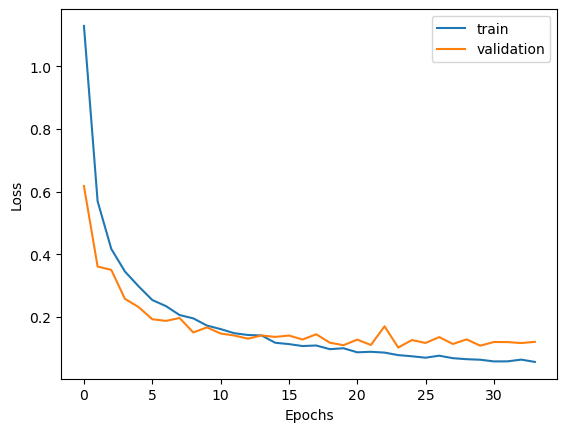

In [10]:
# 构建CNN模型
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 1)),  # 卷积层，提取特征
    layers.BatchNormalization(),  # BatchNormalization层，标准化、加速收敛、减少对权重初始化的依赖
    layers.MaxPooling2D((2, 2)),  # 最大池化层，减小特征图尺寸
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # 将二维特征图展平为一维
    layers.Dense(128, activation='relu'),  # 全连接层，增加非线性
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout层，减少过拟合
    layers.Dense(10, activation='softmax')  # 输出层，10类分类
])

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型时应用早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

# 评估模型
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")

# 可视化训练过程
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**结果分析：**

对比手写的KNN和sklearn的KNN，可以发现CNN是优于KNN算法的，准确率一般都有0.96+，最高可以达到0.97+

而且这个卷积神经网络并不复杂、我也没有过多调参，如果增加一些复杂性或者选择更合适的参数，准确率定可以接近99%